# U-Net Brain Tumor Segmentation

In [890]:
import tensorflow as tf
import keras
from keras.callbacks import Callback
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import TensorBoard

import numpy as np
import os
import SimpleITK as sitka
import random
import matplotlib.pyplot as plt
import importlib

import time

# Data augmentation
import cv2
from albumentations import (
    Compose, HorizontalFlip, VerticalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,
    ToFloat, ShiftScaleRotate, ElasticTransform, Rotate, RandomScale, GridDistortion, OpticalDistortion, OneOf
)

In [891]:
import datagen
import model

In [892]:
# Reload lib contents
importlib.reload(datagen)
importlib.reload(model)

<module 'model' from 'C:\\Users\\krcma\\Desktop\\tf_segmentation\\unet_segmentation\\model.py'>

##  Hyperparemeters

In [893]:
train_HGG_patients = 239
valid_HGG_patients = 20
slices_from_patient = 15
image_size = 240
channels = 4
# learning_rate = 0.0001
learning_rate = 5e-1
epochs = 25
batch_size = 10

## Dataset

In [894]:
x_train, y_train = datagen.get_dataset(slices_from_patient, 
                file_path='../dataset/', 
                mode='training', 
                glioma_type=['HGG'], 
                tumor_region=-1, 
                slices_w_tumor_only=False,
                slices_w_less_brain=None,
                image_size=image_size,
                train_HGG_patients=train_HGG_patients)

training data with shape: (3585, 4, 240, 240) (3585, 1, 240, 240)


In [895]:
x_valid, y_valid = datagen.get_dataset(slices_from_patient, 
                file_path='../dataset/', 
                mode='validation', 
                glioma_type=['HGG'], 
                tumor_region=-1, 
                slices_w_tumor_only=False,
                slices_w_less_brain=None,
                image_size=240,
                train_HGG_patients=valid_HGG_patients)

validation data with shape: (300, 4, 240, 240) (300, 1, 240, 240)


## Model (U-Net)

In [896]:
model = model.UNet(channels, image_size)
adam_optimizer = keras.optimizers.Adam(learning_rate=learning_rate, 
                                       beta_1=0.9, 
                                       beta_2=0.999)
sgd_optimizer = keras.optimizers.SGD(learning_rate=learning_rate, 
                                     momentum=0.5, 
                                     nesterov=True)
model.compile(optimizer=adam_optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy"]
             )

Compiled with input shape (None, 4, 240, 240)


## Data  augmentation

In [897]:
AUGMENTATIONS = Compose([
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
#     Rotate(limit=90, p=0.99),
#     RandomGamma(gamma_limit=(80, 120), p=0.25),
#     RandomScale(scale_limit=0.1, interpolation=cv2.INTER_NEAREST, p=0.25),
#     ElasticTransform(alpha=1, p=0.5),
#     OneOf([
#         OpticalDistortion(p=0.3),
#         GridDistortion(p=0.1),
#     ], p=0.2),
    OpticalDistortion(p=0.5),
    GridDistortion(p=0.5),
])

In [903]:
class Datagen(keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size, augmentations):
        self.x, self.y = x_set, y_set
        self.x_aug, self.y_aug = x_set, y_set
        self.batch_size = batch_size
        self.augment = augmentations

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        if len()
        batch_x = np.array(self.x[idx * self.batch_size:(idx + 1) * self.batch_size], dtype="float32")
        batch_y = np.array(self.y[idx * self.batch_size:(idx + 1) * self.batch_size], dtype="float32")            
        return np.array(batch_x), np.array(batch_y)
    
    def on_epoch_end(self):
        data_x = []
        data_y = []
        
        if self.augment:
            for img, mask in zip(self.x, self.y):
                
                if np.count_nonzero(mask): # Final control if mask contains tumor labels
                    
                    try:
                        augmented = self.augment(image=img, mask=mask)
#                         print("Test print", img.shape, mask.shape)
                    except Exception as e:
#                         print(e)
                        f, axarr = plt.subplots(1,2)
                        axarr[0].imshow(img[0]) #, cmap='gray', vmin=0
                        axarr[1].imshow(mask[0], alpha=1)
                    data_x.append(augmented["image"])
                    data_y.append(augmented["mask"])
                else:
                    data_x.append(img)
                    data_y.append(mask)
        else:
            data_x, data_y = batch_x, batch_y
            
        self.x_aug = np.array(data_x)
        self.y_aug = np.array(data_y)
        
        return np.array(data_x), np.array(data_y)

In [904]:
train_gen = Datagen(x_train, y_train, batch_size, AUGMENTATIONS)

Mask values: [0.]
(240, 240) (240, 240)


C:\Users\krcma\.conda\envs\tfgpu\lib\site-packages\matplotlib\image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
C:\Users\krcma\.conda\envs\tfgpu\lib\site-packages\matplotlib\image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
C:\Users\krcma\.conda\envs\tfgpu\lib\site-packages\matplotlib\image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
C:\Users\krcma\.conda\envs\tfgpu\lib\site-packages\matplotlib\image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
C:\Users\krcma\.conda\envs\tfgpu\lib\site-packages\numpy\ma\core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


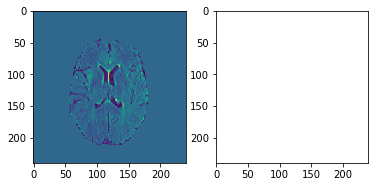

In [905]:
i = random.randint(0,238)
foo_x, foo_y = train_gen.__getitem__(i)
im = foo_x[0][0]
m = foo_y[0][0]

print("Mask values:", np.unique(m))

print(im.shape, m.shape)
m[m == 0] = np.nan

f, axarr = plt.subplots(1,2)
axarr[0].imshow(im)
axarr[1].imshow(m, alpha=1)

## Callbacks

In [906]:
callbacks = [
    keras.callbacks.callbacks.TerminateOnNaN(),
    keras.callbacks.callbacks.EarlyStopping(monitor='val_loss', 
                                            min_delta=0.0001, 
                                            patience=10, 
                                            verbose=1, 
                                            mode='auto', 
                                            baseline=None, 
                                            restore_best_weights=True),
#     TensorBoard(log_dir="logs/{}".format(time()))
]

# Training

In [907]:
train_steps = train_HGG_patients * slices_from_patient
valid_steps = valid_HGG_patients * slices_from_patient

# hist = model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
#                     epochs=epochs, shuffle=True, callbacks=callbacks)

# hist = model.fit(x=x_train, y=y_train, validation_data=(x_valid, y_valid), 
#                     epochs=epochs, callbacks=callbacks, batch_size=batch_size)

hist = model.fit_generator(train_gen, validation_data=(x_valid, y_valid), steps_per_epoch=train_steps,
                    epochs=epochs, callbacks=callbacks)

# model.save("../models/2020040100.h5")

Epoch 1/25
3585/3585 [==============================] - 2101s 586ms/step - loss: 55.2743 - accuracy: 0.0196 - val_loss: 77.9913 - val_accuracy: 0.0177
Epoch 2/25
3585/3585 [==============================] - 2084s 581ms/step - loss: 32.2431 - accuracy: 0.3743 - val_loss: 2.3592e-06 - val_accuracy: 0.7329
Epoch 3/25
1889/3585 [==============>...............] - ETA: 16:17 - loss: 1.6920e-06 - accuracy: 0.7824

KeyboardInterrupt: 

### Results

In [ ]:
# Plot training & validation accuracy values
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(x_valid[0][0]) #, cmap='gray', vmin=0
axarr[1].imshow(y_valid[0][0]) #, cmap='gray', vmin=0
axarr[2].imshow(pred[0][0]) #, cmap='gray', vmin=0